---
title: "Module 05: Lab 02"
subtitle: "Regression Modeling on Employment Data"
author:
  - name: Norah Jones
    affiliations:
      - id: cmu
        name: Carnegie Mellon University
        city: Pittsburgh
        state: PA
      - id: chicago
        name: University of Chicago
        city: Chicago
        state: IL
  - name: John Hamm
    affiliations:
      - ref: cmu
      - name: University of California, San Diego
        city: San Diego
        state: CA
number-sections: true
date: "2024-11-21"
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
date-modified: today
date-format: long
execute: 
  echo: false
  eval: false
  freeze: auto
---

# Objectives {.unnumbered}

1. Use **PySpark** to process the Lightcast dataset.
2. Engineer features from structured columns for salary prediction.
3. Train **Linear Regression model**.
4. Evaluate models using **RMSE** and **R²**.
5. Visualize predictions using diagnostic plots.
6. Push work to GitHub and submit the repository link.

# Setup {.unnumbered}

The instruction below provides you with general keywords for columns used in the lightcast file. See the data schema generated after the load dataset code above to use proper column name. For visualizations, tables, or summaries, please **customize colors, fonts, and styles** as appropriate to avoid a **2.5-point deduction**. Also, **provide a two-sentence explanation** describing key insights drawn from each section's code and outputs. 

1. Follow the steps below as necessary, use your best judgement in importing/installing/creating/saving files as needed.
2. Create a new Jupyter Notebook in your `ad688-sp25-lab08` directory named `lab08_yourname.ipynb`, if the file exists make sure to change the name.
3. Use your **EC2 instance** for this lab.
4. Ensure the `lightcast_data.csv` file is available on the EC2 instance. if not then **Download the dataset**
5. **Add the dataset to `.gitignore`** to avoid pushing large files to GitHub. Open your `.gitignore` file and add:
6. Make sure to create a virtual environment and install the required Python libraries if needed, don't forget to activate it:
7. Install the required Python libraries if needed, you can also use the given requirement file to install the packages to the virtual environment:

```bash
python3 -m venv .venv
source .venv/bin/activate
gdown https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ
echo "lightcast_job_postings.csv" >> .gitignore
pip install -r requirements.txt
```


# Load the Dataset
1. **Load the Raw Dataset**:
   - Use Pyspark to the `lightcast_data.csv` file into a DataFrame:
   - You can reuse the previous code. 
   - [Copying code from your friend constitutes plagiarism. DO NOT DO THIS]{.uured-bold}.

In [14]:
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
import scipy as sc
import statsmodels.api as sm

pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()



In [1]:
from pyspark.sql import SparkSession
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

# Initialize Spark session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load the data
df = spark.read.option("header", "true") \
               .option("inferSchema", "true") \
               .option("multiLine", "true") \
               .option("escape", "\"") \
               .csv("data/lightcast_job_postings.csv")

# Show schema (just for debug, comment out later)
#df.printSchema()
#df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/16 23:41:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Feature Engineering

Feature Engineering is a crucial step in preparing your data for machine learning. In this lab, we will focus on the following tasks:

1. **Drop rows with missing values** in the target variable and key features.
2. By now you are already familiar with the code and the data. Based on your understanding please choose any 3 (my code output has 10) variables as:
   1. two continuous variables (use your best judgment!)
   2. one categorical.
   3. Your dependent variable (y) is `SALARY`.
3. **Convert categorical variables** into numerical representations using **StringIndexer** and **OneHotEncoder**.
4. **Assemble features** into a single vector using **VectorAssembler**.
5. **Split the data** into training and testing sets.

In [2]:
df = df.dropna(subset=["MIN_YEARS_EXPERIENCE", "MODELED_DURATION", "EMPLOYMENT_TYPE_NAME", "SALARY"])
continuous_features = ["MIN_YEARS_EXPERIENCE", "MODELED_DURATION"]
categorical_feature = "EMPLOYMENT_TYPE_NAME"
target = "SALARY"



In [3]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Define input columns
continuous_features = ["MIN_YEARS_EXPERIENCE", "MODELED_DURATION"]
categorical_feature = "EMPLOYMENT_TYPE_NAME"
target = "SALARY"

# Index and encode the categorical feature
indexer = StringIndexer(inputCol=categorical_feature, outputCol=f"{categorical_feature}_Index")
encoder = OneHotEncoder(inputCols=[f"{categorical_feature}_Index"], outputCols=[f"{categorical_feature}_OHE"])

# Vector assembler to combine all features
assembler = VectorAssembler(
    inputCols=continuous_features + [f"{categorical_feature}_OHE"],
    outputCol="features"
)

# Create pipeline
pipeline = Pipeline(stages=[indexer, encoder, assembler])

# Fit and transform the data
pipeline_model = pipeline.fit(df)
df_transformed = pipeline_model.transform(df)

# Final dataset
df_final = df_transformed.select(target, "features")
df_final.show(5, truncate=False)

+------+-------------------+
|SALARY|features           |
+------+-------------------+
|107645|[10.0,41.0,1.0,0.0]|
|192800|[6.0,55.0,1.0,0.0] |
|125900|[12.0,18.0,1.0,0.0]|
|170000|[6.0,55.0,1.0,0.0] |
|118560|[5.0,20.0,1.0,0.0] |
+------+-------------------+
only showing top 5 rows



# Train/Test Split

- Perform a **random split** of the data into training and testing sets.
- Set a random seed for reproducibility.
- You can choose a number for splitting to your liking, justify your choice.

In [4]:
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

print(f"Training count: {train_data.count()}")
print(f"Testing count: {test_data.count()}")

Training count: 13541


Testing count: 3299


# Linear Regression

- Train a **Linear Regression** model using the training data. [You will run in to an important issue here. Please make an effort in figuring it by yourself. This is one of the most asked interview questions in CapitalOne's management recruiting program.]{.uured-bold}
- Evaluate the model on the test data.
- Print the coefficients, intercept, R², RMSE, and MAE.
- Use the `summary` object to extract the coefficients and their standard errors, t-values, and p-values.
- Create a DataFrame to display the coefficients, standard errors, t-values, p-values, and confidence intervals.
- Interpret the coefficients and their significance and explain the model performance metrics.

In [5]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="SALARY")
lr_model = lr.fit(train_data)
summary = lr_model.summary

25/04/16 23:42:10 WARN Instrumentation: [41766181] regParam is zero, which might cause numerical instability and overfitting.


In [6]:
print("Intercept:", lr_model.intercept)
print("Coefficients:", lr_model.coefficients)
print("R²:", summary.r2)
print("RMSE:", summary.rootMeanSquaredError)
print("MAE:", summary.meanAbsoluteError)

Intercept: 82403.16103240615
Coefficients: [6628.115858094893,49.91595819833301,761.7205425626963,-2956.9708108534655]
R²: 0.2657513866506249
RMSE: 36587.04555385701
MAE: 28512.579724947576


In [7]:
test_results = lr_model.evaluate(test_data)
print("Test R²:", test_results.r2)
print("Test RMSE:", test_results.rootMeanSquaredError)
print("Test MAE:", test_results.meanAbsoluteError)

Test R²: 0.25557734082393047
Test RMSE: 36627.96824284971
Test MAE: 28109.38835795928


In [8]:
print("Estimate length:", len(lr_model.coefficients))
print("Std Error length:", len(summary.coefficientStandardErrors))
print("t-Value length:", len(summary.tValues))
print("P-Value length:", len(summary.pValues))

Estimate length: 4
Std Error length: 5
t-Value length: 5
P-Value length: 5


In [9]:
import pandas as pd

# Combine intercept and coefficients
estimates = [lr_model.intercept] + list(lr_model.coefficients)

# Now build the DataFrame
coefs_df = pd.DataFrame({
    "Estimate": estimates,
    "Std Error": summary.coefficientStandardErrors,
    "t-Value": summary.tValues,
    "P-Value": summary.pValues
})

# Set row labels
coefs_df.index = ["Intercept"] + [f"Feature {i}" for i in range(len(lr_model.coefficients))]

coefs_df.reset_index(inplace=True)
coefs_df.rename(columns={"index": "Feature"}, inplace=True)

coefs_df

,Feature,Estimate,Std Error,t-Value,P-Value
0,Intercept,82403.161032,95.373673,69.496284,0.000000
1,Feature 0,6628.115858,24.419020,2.044143,0.040959
2,Feature 1,49.915958,2358.657159,0.322947,0.746741
3,Feature 2,761.720543,3055.206330,-0.967847,0.333138
4,Feature 3,-2956.970811,2409.126013,34.204587,0.000000


##Linear Regression Summary

Intercept (82403): This is the baseline predicted salary when all features are zero. It likely represents the average base salary in your dataset.

**Feature 0:**
Positive impact (+6628).
Statistically significant (p = 0.041).

**Interpretation:** A one-unit increase in this feature is associated with a $6,628 increase in salary, holding other variables constant.

**Feature 1 & Feature 2:**
High standard errors and large p-values.
Not statistically significant (p > 0.05).
Likely don't contribute meaningful prediction power to the model.
May consider removing them or reviewing for multi-collinearity.

**Feature 3:**
Large negative effect (−$2957 per unit).
Highly significant.
Might represent a penalty factor like higher gaps, outdated skills, or maybe a categorical factor inversely associated with salary.


The summary of the Generalized Linear Regression model provides important insights into the model's performance and the significance of each feature. The coefficients indicate the relationship between each feature and the target variable (salary), while the standard errors, t-values, and p-values help assess the reliability of these estimates.

- Please interpret them in the context of your data and model. 
- Feature Names are purposefully not printed in the output. You can use the `features` variable to print them out.

# Diagnostic Plot

Diagnostic plots are essential for evaluating the performance of regression models. In this section, we will create several diagnostic plots to assess the linear regression model's assumptions and performance. There are four (2*2 grid) main plots we will create, you can use `seaborn` or `matplotlib` for this:

1. **Predicted vs Actual Plot**
2. **Residuals vs Predicted Plot**
3. **Histogram of Residuals**
4. **QQ Plot of Residuals**


In [10]:
predictions = lr_model.transform(test_data)
from pyspark.sql import functions as F

predictions_with_residuals = predictions.withColumn("Residual", F.col("SALARY") - F.col("prediction"))
predictions_df = predictions_with_residuals.select("SALARY", "prediction", "Residual").toPandas()
predictions_df.columns = ["Actual", "Predicted", "Residual"]
predictions_df.head()


,Actual,Predicted,Residual
0,22880,88420.356115,-65540.356115
1,24960,91340.392137,-66380.392137
2,29120,86922.877369,-57802.877369
3,31200,80294.761511,-49094.761511
4,31200,116505.124698,-85305.124698


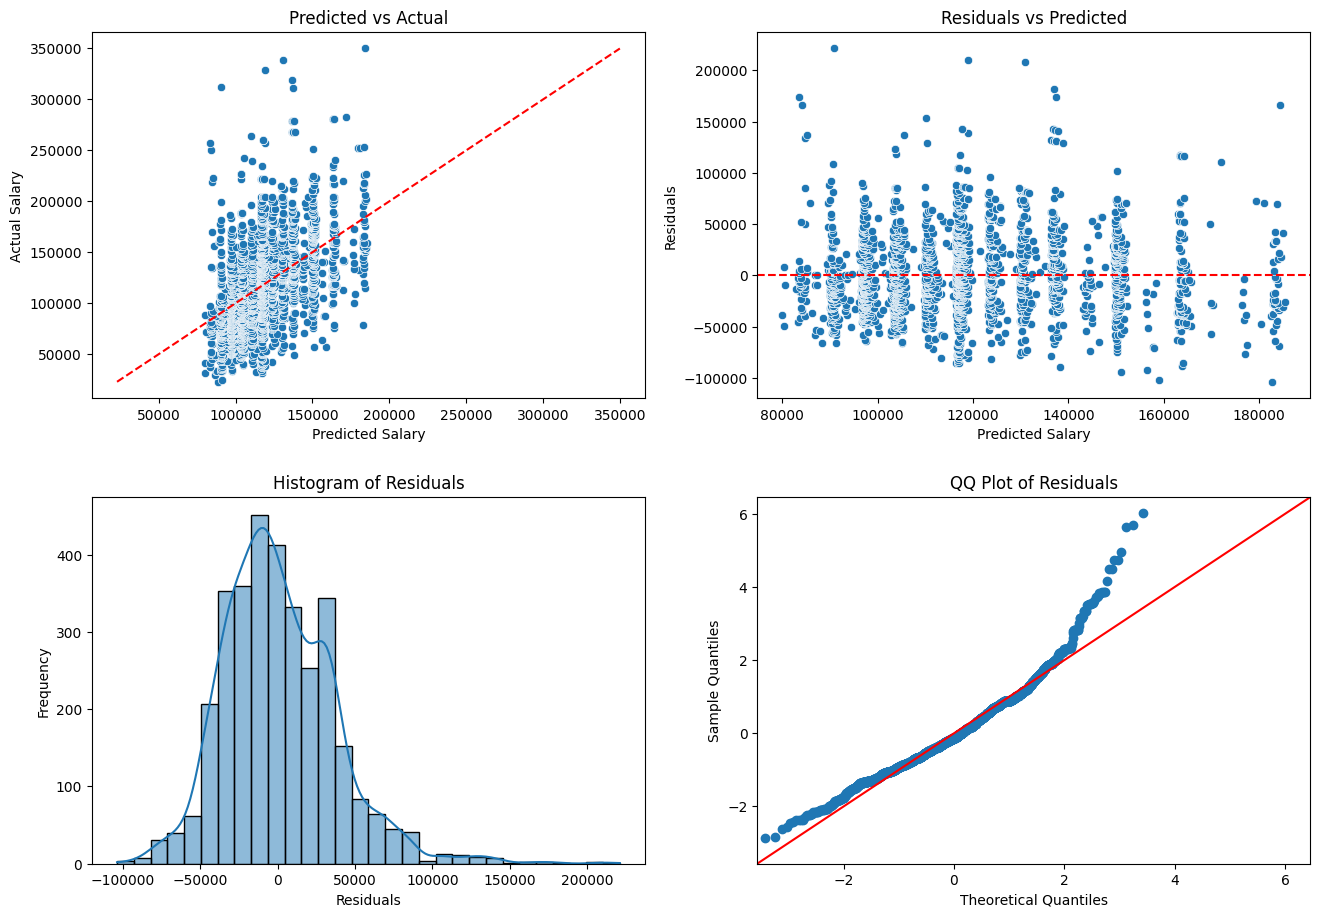

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
plt.tight_layout(pad=5)

# Plot 1: Predicted vs Actual
sns.scatterplot(x='Predicted', y='Actual', data=predictions_df, ax=axs[0, 0])
axs[0, 0].plot([predictions_df['Actual'].min(), predictions_df['Actual'].max()],
               [predictions_df['Actual'].min(), predictions_df['Actual'].max()],
               color='red', linestyle='--')
axs[0, 0].set_title('Predicted vs Actual')
axs[0, 0].set_xlabel('Predicted Salary')
axs[0, 0].set_ylabel('Actual Salary')

# Plot 2: Residuals vs Predicted
sns.scatterplot(x='Predicted', y='Residual', data=predictions_df, ax=axs[0, 1])
axs[0, 1].axhline(0, color='red', linestyle='--')
axs[0, 1].set_title('Residuals vs Predicted')
axs[0, 1].set_xlabel('Predicted Salary')
axs[0, 1].set_ylabel('Residuals')

# Plot 3: Histogram of Residuals
sns.histplot(predictions_df['Residual'], kde=True, ax=axs[1, 0], bins=30)
axs[1, 0].set_title('Histogram of Residuals')
axs[1, 0].set_xlabel('Residuals')
axs[1, 0].set_ylabel('Frequency')

# Plot 4: QQ Plot of Residuals
sm.qqplot(predictions_df['Residual'], fit=True, line="45", ax=axs[1, 1])
axs[1, 1].set_title('QQ Plot of Residuals')

plt.show()

# Evaluation

The evaluation of the model is crucial to understand its performance. In this section, we will calculate and visualize the following metrics:
1. **R² (Coefficient of Determination)**: Indicates how well the model explains the variance in the target variable.
2. **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values.

In [12]:
from pyspark.ml.evaluation import RegressionEvaluator

# Predict on test data
predictions = lr_model.transform(test_data)

# Evaluators
r2_evaluator = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
rmse_evaluator = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")
mae_evaluator = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="mae")

# Compute metrics
r2 = r2_evaluator.evaluate(predictions)
rmse = rmse_evaluator.evaluate(predictions)
mae = mae_evaluator.evaluate(predictions)

print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

R²: 0.2556
RMSE: 36627.97
MAE: 28109.39


## Model Evaluation Plot

- Display the predicted vs actual salary plot with a red line indicating the ideal fit (y=x).
- Use `seaborn` or `matplotlib` to create the plot.
- Customize the plot with appropriate titles, labels, and legends.
- Describe the plot in a few sentences, highlighting key insights and observations.

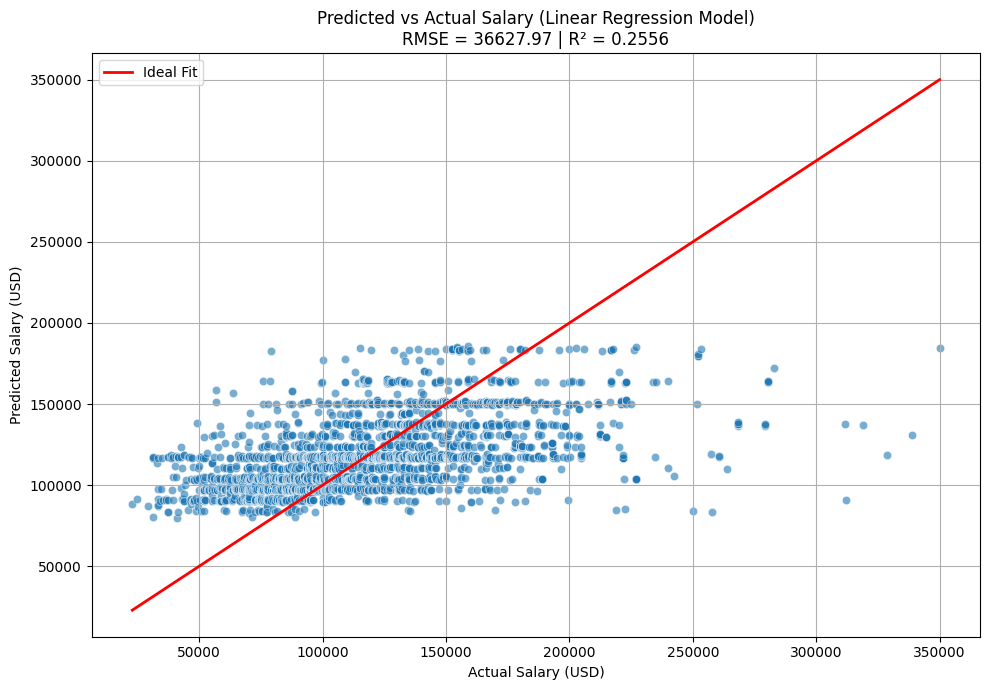

In [13]:
# Create the plot
plt.figure(figsize=(10, 7))
sns.scatterplot(x='Actual', y='Predicted', data=predictions_df, alpha=0.6)

# Add the ideal fit line (y = x)
max_val = max(predictions_df['Actual'].max(), predictions_df['Predicted'].max())
min_val = min(predictions_df['Actual'].min(), predictions_df['Predicted'].min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='-', linewidth=2, label='Ideal Fit')

# Titles and labels
plt.title('Predicted vs Actual Salary (Linear Regression Model)\nRMSE = {:.2f} | R² = {:.4f}'.format(rmse, r2))
plt.xlabel('Actual Salary (USD)')
plt.ylabel('Predicted Salary (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Submission {.unnumbered}
1. Save figures in the `_output/` folder.
2. Commit and push code and output files:
```bash
git add .
git commit -m "Add Lab 08 Salary Prediction models and output"
git push origin main
```
3. Submit your GitHub repository link.

# Resources {.unnumbered}
- [PySpark MLlib Docs](https://spark.apache.org/docs/latest/ml-guide.html)  
- [Seaborn Docs](https://seaborn.pydata.org/)  
- [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html)
